In [13]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt

import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.preprocessing import preprocess

In [14]:
data_path = "../data/"
database = "final_merged_dataset.csv"
df = pd.read_csv(data_path + database)
df['Unnamed: 0'] = [i for i in range(len(df))] #c'est moche mais ca marche c'est la vie 
df.columns = ['index', 'tweet', 'label']

_, _, df = preprocess(df)
print(df.tail())

       index                                              tweet  label  \
31996  31996  https://t.co/inx3HTRcfR Smell Diminishes by Da...      1   
31997  31997  COVID-19 outbreak on the Diamond Princess crui...      1   
31998  31998  Coronavirus China Italy | Coronavirus Outbreak...      1   
31999  31999  Coronavirus Daily Digest: April 13, 2020\nhttp...      1   
32000  32000  Detention centers are notorious for having poo...      1   

                                              preprocess  
31996        smell diminishes day 3 covid-19, study says  
31997  covid-19 outbreak diamond princess cruise ship...  
31998  coronavirus china italy | coronavirus outbreak...  
31999           coronavirus daily digest: april 13, 2020  
32000  detention centers notorious having poor condit...  


In [15]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = df['preprocess'] # use 'preprocess' for preprocessed tweets, 'tweets' for unpreprocessed
vectorizer = CountVectorizer(max_features = 100)
vectorizer.fit(corpus)
X = vectorizer.transform(corpus).toarray()
Y = df['label']

When we used TfIdf, performance dropped, so we just dropped it as well.

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
transformer.fit(X)
X = transformer.transform(X).toarray()

In [18]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import KFold, cross_val_score

clf = RandomForestClassifier(n_estimators=50)

score = cross_val_score(clf, X , Y)
print('Mean : %.2f' % score.mean())
print('Std :  %.2f' % score.std())

Mean : 0.78
Std :  0.02


In [19]:
from sklearn.metrics import classification_report
folds = 5
kf = KFold(n_splits=folds, shuffle=True, random_state=0) 

count = 0
for train_index, test_index in kf.split(X,Y):
    count += 1
    X_train, X_test = X[train_index, :], X[test_index, :]
    Y_train, Y_test = Y[train_index], Y[test_index]
               
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    print('Fold : ', count)
    print(classification_report(Y_pred, Y_test))

Fold :  1
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2702
           1       0.89      0.85      0.87      3699

    accuracy                           0.85      6401
   macro avg       0.85      0.85      0.85      6401
weighted avg       0.85      0.85      0.85      6401

Fold :  2
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      2748
           1       0.89      0.84      0.87      3652

    accuracy                           0.85      6400
   macro avg       0.85      0.85      0.85      6400
weighted avg       0.85      0.85      0.85      6400

Fold :  3
              precision    recall  f1-score   support

           0       0.80      0.86      0.83      2690
           1       0.89      0.85      0.87      3710

    accuracy                           0.85      6400
   macro avg       0.84      0.85      0.85      6400
weighted avg       0.85      0.85      0.85 

Avec train_test_split classique :

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = 0)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

print(classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.81      0.86      0.83      3388
           1       0.89      0.85      0.87      4613

    accuracy                           0.85      8001
   macro avg       0.85      0.85      0.85      8001
weighted avg       0.85      0.85      0.85      8001



(array([10869.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 13131.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

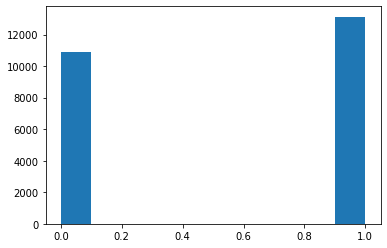

In [21]:
plt.hist(Y_train)

In [22]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(Y_test, Y_pred))

[[2911  705]
 [ 477 3908]]


In [23]:
errors = pd.DataFrame({'location': [], 'text' :[], 'value': [], 'predicted': []})
for i in range(len(Y_pred)):
    if Y_test.values[i] - Y_pred[i] != 0:
        errors = errors.append({
            'location': Y_test.index[i],
            'text': df['tweet'][Y_test.index[i]],
            'preprocess': df['preprocess'][Y_test.index[i]],
            'predicted': Y_pred[i],
            'value': Y_test.values[i]
        }, ignore_index= True)
 
print(errors)

      location                                               text  value  \
0       7745.0  Polish government confiscated a coronavirus te...    0.0   
1      28072.0  Missing link in coronavirus jump from bats to ...    1.0   
2      22301.0  @RickeyLarry @StevO_1960 @Vincentjackson_ @Hub...    0.0   
3      24568.0  Surgeons at Northwestern announced that they p...    1.0   
4      31383.0  Monitoring and Evaluation Logic Model. \nPhoto...    1.0   
...        ...                                                ...    ...   
1177   12051.0  This is a recent picture where hospitals show ...    0.0   
1178   10707.0  Countries were purchasing Covid-19 test kits i...    0.0   
1179   21602.0  @realDonaldTrump “We’ve tested more than every...    0.0   
1180   13340.0  Holy Qur'an was banned in China now ban\r\nHas...    0.0   
1181   14358.0  Delhi Public School Selling Face Masks For Rs....    0.0   

      predicted                                         preprocess  
0           1.0  p

In [24]:
for error in errors.tail().iterrows():
    print('Sample error : \n', error[1]['text'], '\n')
    print('Preprocessed error : \n', error[1]['preprocess'], '\n')
    print('Line : ', error[1]['location'])
    print('Predicted value : ', error[1]['predicted'] , '\nReal value : ', error[1]['value'], '\n')
    print('_______________________________________________\n')

Sample error : 
 This is a recent picture where hospitals show dogs inside the ward 

Preprocessed error : 
 recent picture hospitals dogs inside ward 

Line :  12051.0
Predicted value :  1.0 
Real value :  0.0 

_______________________________________________

Sample error : 
 Countries were purchasing Covid-19 test kits in 2018 

Preprocessed error : 
 countries purchasing covid-19 test kits 2018 

Line :  10707.0
Predicted value :  1.0 
Real value :  0.0 

_______________________________________________

Sample error : 
 @realDonaldTrump “We’ve tested more than every country combined.” Nope. Through April 28, the United States had conducted 5.9 million tests, according to Worldometer. The next five countries — Russia, Germany, Italy, Spain and United Arab Emirates — had conducted 10 million tests as of that date. 

Preprocessed error : 
 “we’ve tested country combined.” nope. april 28, united states conducted 5.9 million tests, according worldometer. countries — russia, germany, ita

In [25]:
words_error = []
for error in errors['text']:
    error_text = re.sub(r'[^\w\s]', '', error)
    words_error += word_tokenize(error_text)

my_stopwords = set(stopwords.words('english')) 

n = 2
words_error = [word for word in words_error if not word in my_stopwords]
ngram_all=(pd.Series(nltk.ngrams(words_error, n)).value_counts())[:30]
ngram_all=pd.DataFrame(ngram_all)
print(ngram_all)

                         0
(new, coronavirus)      26
(tested, positive)      16
(novel, coronavirus)    16
(COVID19, vaccine)      15
(Michigan, Governor)    12
(clinical, trial)       12
(COVID19, pandemic)     11
(COVID19, cases)        10
(Of, Fruit)              9
(A, video)               9
(Governor, Bans)         9
(social, media)          9
(Gardening, Sale)        9
(Sale, Of)               9
(Supplies, Prohibited)   9
(Bans, Gardening)        9
(Fruit, Vegetable)       9
(Gardening, Supplies)    9
(due, COVID19)           9
(Seeds, Gardening)       9
(vaccine, COVID19)       9
(Vegetable, Seeds)       9
(United, States)         9
(positive, COVID19)      9
(World, Health)          8
(New, York)              8
(New, coronavirus)       8
(coronavirus, COVID19)   8
(Vitamin, D)             8
(NIH, clinical)          8
